## Seam Carving Implementation

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy
import scipy.sparse.linalg
import ipywidgets as widgets
import seam_carving

## 1. Upload your own photo

In [ ]:
# TODO: Run this block and upload your own picture using the upload widget

pic_upload = widgets.FileUpload(accept="image/*", multiple=False)
pic_upload

In [ ]:
if len(pic_upload.metadata) == 1:
    file_name = pic_upload.metadata[0]['name']
    content = pic_upload.value[file_name]['content']

    np_array = np.frombuffer(content, np.uint8)
    im = cv2.cvtColor(cv2.imdecode(np_array, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
else:
    print("Error: Please upload 1 picture")

In [ ]:
plt.figure()
plt.imshow(im)
plt.show()

In [ ]:
gray = np.sum(im, axis=2)

energy = np.copy(gray)
energy[1:-1, 1:-1] = (abs(gray[1:-1,1:-1]-gray[:-2,1:-1])+
                      abs(gray[1:-1,1:-1]-gray[2:,1:-1])+
                      abs(gray[1:-1,1:-1]-gray[1:-1,:-2])+
                      abs(gray[1:-1,1:-1]-gray[1:-1,2:]))
#treat last row of energy separately
energy[-1, 1:-1] = (abs(gray[-1,1:-1]-gray[-2,1:-1])+
                    abs(gray[-1,1:-1]-gray[-1,:-2])+
                    abs(gray[-1,1:-1]-gray[-1,2:]))
#NOTE: ignoring top row and left and right edges for now

plt.imshow(energy.astype(np.uint8))
plt.jet()
plt.colorbar()

In [ ]:
energypaths = np.zeros(np.shape(gray))
energypaths[0,:] = energy[0,:]

num_rows, num_cols = np.shape(gray)

for row in range(1,num_rows):
    for col in range(num_cols):
        if col==0:
            energypaths[row,col] = (energy[row,col]+
                                   min(energypaths[row-1,:2]))
        elif col==num_cols-1:
            energypaths[row,col] = (energy[row,col]+
                                    min(energypaths[row-1,col-1:num_cols]))
        else:
            energypaths[row,col] = (energy[row,col]+
                                    min(energypaths[row-1,col-1:col+2]))
            
plt.imshow(energypaths)

In [ ]:
#(3) find the seam running from top edge to bottom edge with the lowest energy

#start at the bottom to find the smallest value of accumulated energy
minima = np.where(energypaths[-1,:]==energypaths[-1,:].min())[0]
#settle ties among multiple equivalent minima by choosing randomly
minimum = np.random.choice(minima)

#for each row above the bottom one, determine the matching column value
colvals = np.zeros(num_rows).astype(int)
colvals[-1] = minimum

for row in np.arange(num_rows-2,-1,-1):
    prevcol = colvals[row+1]
    if prevcol!=0 and prevcol!=num_cols-1:
        if (energypaths[row,prevcol-1]<energypaths[row,prevcol] and 
           energypaths[row,prevcol-1]<energypaths[row,prevcol+1]):
            colvals[row] = prevcol-1
        elif (energypaths[row,prevcol+1]<energypaths[row,prevcol-1] and 
              energypaths[row,prevcol+1]<energypaths[row,prevcol]):
            colvals[row] = prevcol+1
        else:
            colvals[row] = prevcol  
    if prevcol==0:
        if energypaths[row,prevcol]<=energypaths[row,prevcol+1]:
            colvals[row] = prevcol    
        else:
            colvals[row] = prevcol+1
    if prevcol==num_cols-1:
        if energypaths[row,prevcol]<=energypaths[row,prevcol-1]:
            colvals[row] = prevcol    
        else:
            colvals[row] = prevcol-1

In [ ]:
#show the seam to be removed
seamdisplay = np.copy(im)

seamdisplay[range(num_rows),colvals,:]=[255,0,0]
if colvals.min()>0:
    seamdisplay[range(num_rows),colvals-1,:]=[255,0,0]
if colvals.max()<num_cols-2:
    seamdisplay[range(num_rows),colvals+1,:]=[255,0,0]

plt.figure(figsize=(12,12))
plt.imshow(seamdisplay[:,:])

In [ ]:
smallerim = seam_carving.removeseam(im,colvals)
np.shape(smallerim)
plt.imshow(smallerim)
print('Starting image size: {0}'.format(np.shape(seamdisplay)))
print('Resulting image size: {0}'.format(np.shape(smallerim)))

In [2]:
pic_upload = widgets.FileUpload(accept="image/*", multiple=False)
pic_upload

FileUpload(value={}, accept='image/*', description='Upload')

In [8]:
file_name = pic_upload.metadata[0]['name']
content = pic_upload.value[file_name]['content']

np_array = np.frombuffer(content, np.uint8)
original = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

workingim = np.copy(original)

In [9]:
for i in range(300): #todo: give user choice of width and height
    seam, energypaths = seam_carving.find_seam(workingim)
    workingim = seam_carving.removeseam(workingim,seam)

Starting image size: (1439, 1440, 3)
Resulting image size: (1439, 1140, 3)


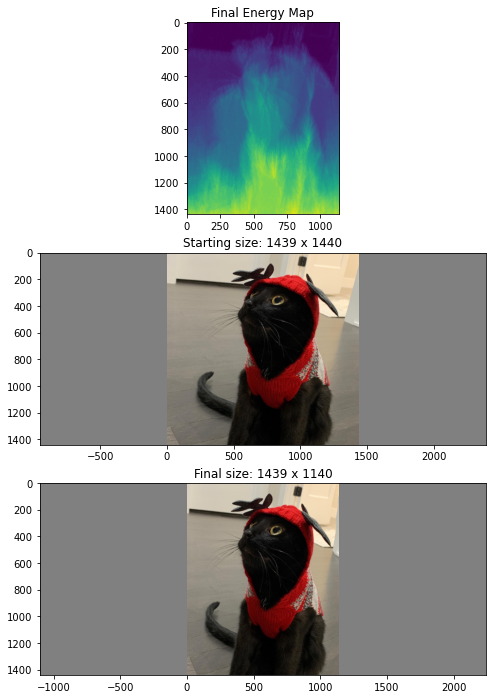

In [10]:
fig = plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.imshow(energypaths)
plt.title('Final Energy Map')

axes = plt.subplot(3,1,2,facecolor='gray')
plt.imshow(original)
plt.title('Starting size: {0} x {1}'.format(np.shape(original)[0],
                                            np.shape(original)[1]))
plt.axis('equal')

plt.subplot(3,1,3,facecolor='gray')
plt.imshow(workingim)
plt.title('Final size: {0} x {1}'.format(np.shape(workingim)[0],
                                         np.shape(workingim)[1]))
plt.axis('equal')

print('Starting image size: {0}'.format(np.shape(original)))
print('Resulting image size: {0}'.format(np.shape(workingim)))